In [ ]:
import torch
from torch import nn # nn contains all of pytorch's building blocks for neural networks
import matplotlib.pyplot as plt

torch.__version__

'2.1.0+cu121'

## 1. Data

In [ ]:
# Create known parameters
weight=0.7
bias=0.3

# Create Data
start=0
end=1
step=0.02
X=torch.arange(start, end, step).unsqueeze(dim=1)
y= weight * X * bias
X[:10],y[:10],X.shape,y.shape

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.0000],
         [0.0042],
         [0.0084],
         [0.0126],
         [0.0168],
         [0.0210],
         [0.0252],
         [0.0294],
         [0.0336],
         [0.0378]]),
 torch.Size([50, 1]),
 torch.Size([50, 1]))

### Train-Validation-Test Split

In [ ]:
# Create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_test), len(y_train), len(y_test)

(40, 10, 40, 10)

In [ ]:
# Visualizing data
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  plt.figure(figsize=(10, 7))
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training Data")
  plt.scatter(test_data, test_labels, c="g", s=4,  label="Testing Data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  plt.legend(prop={"size" : 14})

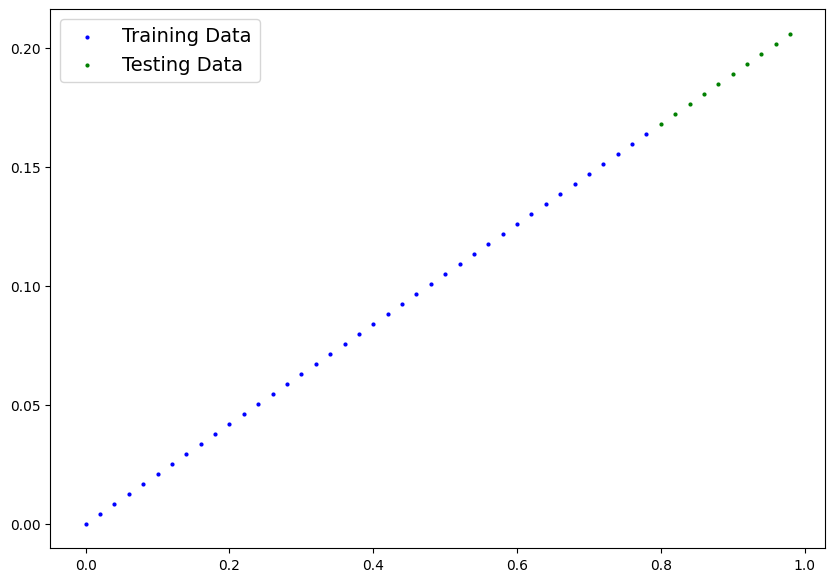

In [ ]:
plot_predictions()

## 2. Build Model


In [ ]:
# Create linear regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch inherits from nn.Module
  # constructor
  def __init__(self):
    super().__init__()

    # Initialize model parameters
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True, # PyTorch will track all the gradients (for gradient descent)
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))

  # Forward method to define the computation in the model
  # Needed for any class that inherits from nn.Module
  def forward(self, x: torch.Tensor) -> torch.Tensor: # x is the input data
    return self.weights * x * self.bias

### PyTorch model building essentials
* torch.nn - contains building blocks for computational graphs (including nnets)
* torch.nn.Parameter - what parameters should the model try and learn...often a PyTorch layer from torch.nn will set these for us
* torch.nn.Module - the base class for all neural network modules (all subclasses need to overwrite forward(), which describes what happens in the forward computation)
* torch.optim - houses the optimizers for PyTorch, will help with gradient descent

In [ ]:
  # Checking contents of PyTorch Model

  torch.manual_seed(42)
  model_0 = LinearRegressionModel()
  list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using torch.inference_mode()

To check model's predictive power, check how well it predicts y_test based on x_test

In [ ]:
# Make predictions with model
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds, y_test

(tensor([[0.0347],
         [0.0356],
         [0.0364],
         [0.0373],
         [0.0382],
         [0.0390],
         [0.0399],
         [0.0408],
         [0.0416],
         [0.0425]]),
 tensor([[0.1680],
         [0.1722],
         [0.1764],
         [0.1806],
         [0.1848],
         [0.1890],
         [0.1932],
         [0.1974],
         [0.2016],
         [0.2058]]))

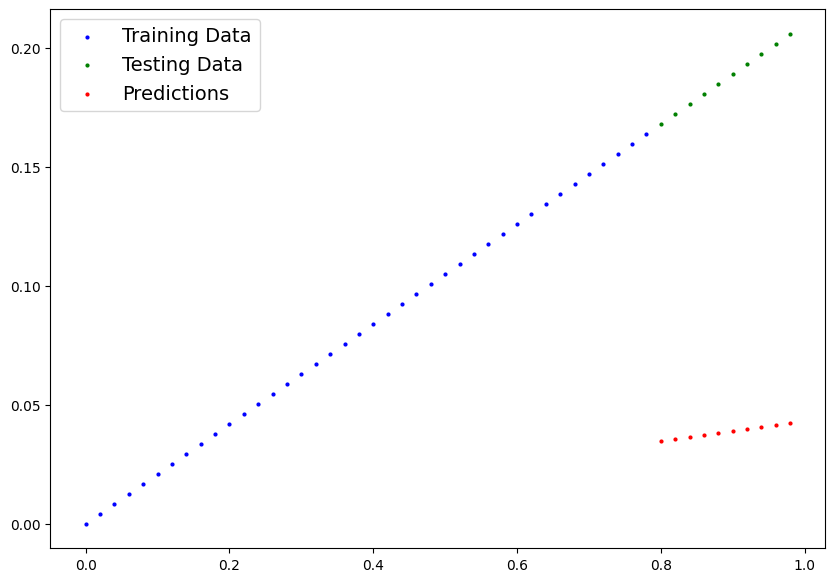

In [ ]:
plot_predictions(predictions=y_preds)

## 3. Train model

The idea of training is for a model to move from some unknown parameters to some known ones

One way to measure how poot or how wrong models are is by using a loss function

Things we need to train:
* Loss function: A function to measure how wrong your model's predictions are compared to the ideal output
  * For NNs: https://pytorch.org/docs/stable/nn.html#loss-functions (torch.optim)
* Optimizer: takes into account the loss of a model and adjusts the model's parameters
* Specifically for PyTorch:
  * Training Loop
  * Testing Loop


In [ ]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an (SGD) optimizer, with the two needed parameters
optimizer = torch.optim.SGD(params=model_0.parameters(), # what parameters to optimize
                            lr=0.01) # lr = learning rate is one of the most important hyperparameters that determines how big/small the optimizer changes

# Which loss function and optimizer to choose depend on the problem!

In [ ]:
loss_fn

L1Loss()

### Building a training loop (and testing loop) in PyTorch

What we need:
0. Loop through the data
  1. Foward pass (this involves data moving through the mode's `forward()` function(s) to make predictions, also called forward propogation)
  2. Calculate the loss (compare forward pass predictions to ground truth labels)
  3. Zero the gradients of the optimizer
  4. Backpropagation - move backwards through the network to calculate the gradients of each of the parameters with respect to the loss
  5. Gradient Descent - use the optmizer to adjust out model's parameeters to try and improve the loss

In [ ]:
# An epoch is one loop through the data... this is a hyperparameter because we've set this ourself
epochs = 250

# Keep track of important variables.
epoch_list = []
losses = []
test_losses = []

torch.manual_seed(42)
# 0. Loop through data
for epoch in range(epochs):
  epoch_list.append(epoch)

  # Set the model to training mode
  model_0.train() # train mode in PyTorch sets all parameters that require gradients to require gradients (`requires_grad=True`)

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)
  losses.append(loss.item())

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. backprop
  loss.backward()

  # 5. Gradient Descent
  optimizer.step() # How the optmizer changes will accumulate through the loop, so we have to zero them above in (3)

  ### Testing
  model_0.eval() # turns off gradient tracking (`requires_grad=False`) and other settings in the model not needed for testing
  with torch.inference_mode(): # turns off gradient tracking (and other things not needed for testing)
    # 1. Do the forward pass in testing mode
    test_pred = model_0(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)
    test_losses.append(test_loss)

  # Print Statement
  if epoch % 25 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

print(model_0.state_dict())

Epoch: 0 | Loss: 0.06498613208532333 | Test loss: 0.14785005152225494
Epoch: 25 | Loss: 0.05969914048910141 | Test loss: 0.13571719825267792
Epoch: 50 | Loss: 0.053569622337818146 | Test loss: 0.12164188921451569
Epoch: 75 | Loss: 0.046364493668079376 | Test loss: 0.10508892685174942
Epoch: 100 | Loss: 0.037809818983078 | Test loss: 0.08542895317077637
Epoch: 125 | Loss: 0.027580415830016136 | Test loss: 0.06191468983888626
Epoch: 150 | Loss: 0.015287525951862335 | Test loss: 0.03365245833992958
Epoch: 175 | Loss: 0.00046394640230573714 | Test loss: 0.00043183713569305837
Epoch: 200 | Loss: 0.00015927778440527618 | Test loss: 0.001132224453613162
Epoch: 225 | Loss: 0.0005258441669866443 | Test loss: 0.0002894461213145405
OrderedDict([('weights', tensor([0.5137])), ('bias', tensor([0.4093]))])


In [ ]:
print(model_0.state_dict())

OrderedDict([('weights', tensor([0.5137])), ('bias', tensor([0.4093]))])


In [ ]:
weight,bias

(0.7, 0.3)

In [ ]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

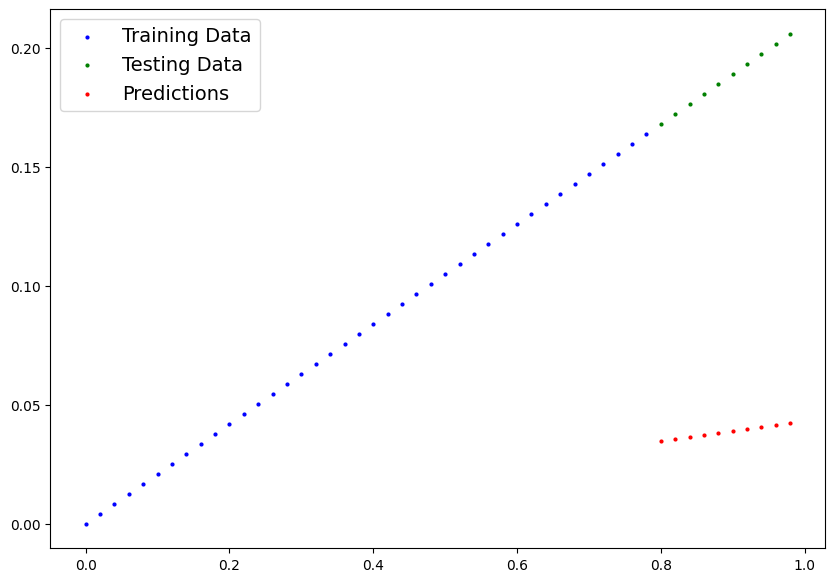

In [ ]:
plot_predictions(predictions=y_preds)

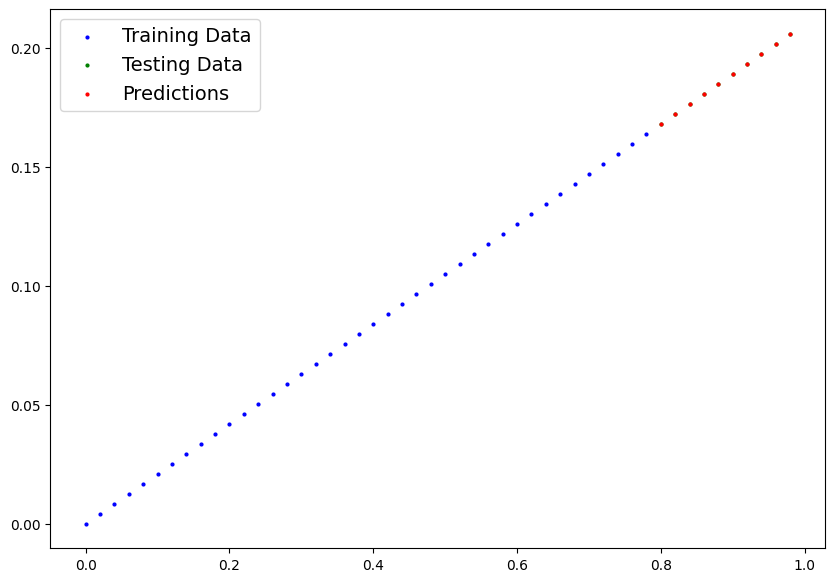

In [ ]:
plot_predictions(predictions=y_preds_new)

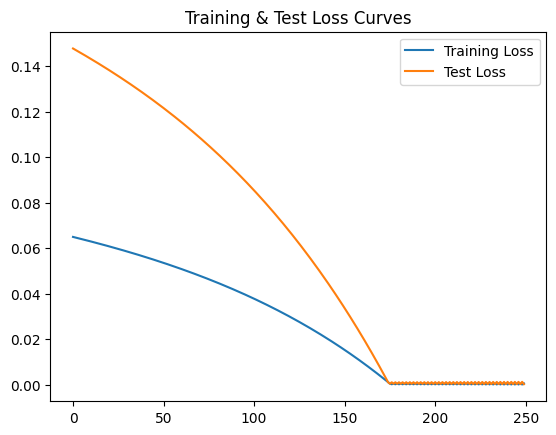

In [ ]:
plt.plot(epoch_list, losses, label="Training Loss")
plt.plot(epoch_list, test_losses, label="Test Loss")
plt.title("Training & Test Loss Curves")
plt.legend()
plt.show()

## Saving a Model in PyTorch

There are three main methods for saving/loading models
1. `torch.save()` allows you to save a PyTorch object in Python's .pkl format.
2. `torch.load()` allows you to load a saved PyTorch object.
3. `torch.nn.Module.load_state_dict()` allows you to load a model's saved state dictionary (a dictionary that holds the states of your model's parameters).

In [ ]:
# Saving our PyTorch model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model).pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME


# 3. Save the model state dict
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

In [ ]:
!ls -l models

total 4
-rw-r--r-- 1 root root 1674 Jan  7 17:23 '01_pytorch_workflow_model).pth'


In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.5137])), ('bias', tensor([0.4093]))])

In [ ]:
# Load Saved Model
loaded_model_0 = LinearRegressionModel()
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [ ]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.5137])), ('bias', tensor([0.4093]))])

In [ ]:
# Make Predictions with loaded model
loaded_model_0.eval()
model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)
  y_preds = model_0(X_test)

y_preds == loaded_model_preds # Check both models are the same (they are).

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Putting it all together
(putting everything from above in one place)

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.1.0+cu121'

In [ ]:
# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


### 6.1 Data

In [ ]:
# Create dummy data step
X = torch.arange(start = 0,
                 end = 5,
                 step = 0.01).unsqueeze(dim=1)
torch.manual_seed(69)
Y = torch.add(0.5 * X, torch.rand(X.shape)) + 4.5
X.shape, Y.shape

(torch.Size([500, 1]), torch.Size([500, 1]))

In [ ]:
# Train-Test Split
X_train, y_train = X[:400], Y[:400]
X_test, y_test = X[400:], Y[400:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([400, 1]),
 torch.Size([400, 1]),
 torch.Size([100, 1]),
 torch.Size([100, 1]))

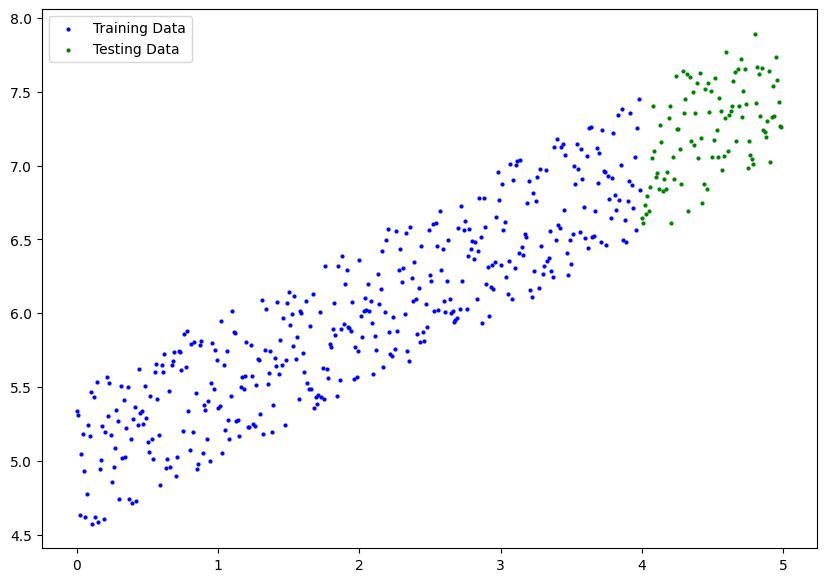

In [ ]:
# Function to visualize data
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  plt.figure(figsize=(10, 7))
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training Data")
  plt.scatter(test_data, test_labels, c="g", s=4,  label="Testing Data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  plt.legend()

plot_predictions()

### 6.2 Build Model

In [ ]:
# Define Model
class LRModel(nn.Module):
  def __init__(self):
    super().__init__()

    # Use nn.Linear() for creating the model parameters
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x) # applies a linear transformation to the data

In [ ]:
# Instaintiate model
torch.manual_seed(69)
lrModel = LRModel()
lrModel, lrModel.state_dict()

(LRModel(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.6796]])),
              ('linear_layer.bias', tensor([0.6083]))]))

In [ ]:
# Set the model to use the target device
lrModel.to(device)
next(lrModel.parameters()).device

device(type='cpu')

### 6.3 Training Loop

In [ ]:
a

In [ ]:
# Set a loss function and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=lrModel.parameters(),
                            lr=0.001)

In [ ]:
torch.manual_seed(69)

num_epochs = 15000
epoch_list = []
loss_list = []
test_loss_list = []

# Device Agnostic code for data
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(num_epochs):
  epoch_list.append(epoch)

  ### TRAINING SECTION ###

  # 0. Set model to train mode
  lrModel.train()

  # 1. Forward pass - make predictions
  y_pred = lrModel(X_train)

  # 2. Calculate loss
  loss = loss_fn(y_pred, y_train)
  loss_list.append(loss.item())

  # 3. Set gradient to zero (so changes in gradient descent will be correct)
  optimizer.zero_grad()

  # 4. Backpropagation
  loss.backward()

  # 5. Gradient Descent
  optimizer.step()

  ### TESTING SECTION ###

  # Set model to test mode
  lrModel.eval()
  with torch.inference_mode():

    # Make test predictions
    y_test_pred = lrModel(X_test)

    # Calculate test loss
    test_loss = loss_fn(y_test_pred, y_test)
    test_loss_list.append(test_loss.item())

  ### PRINT STATEMENT ###
  if epoch % 1000 == 0:
    print(f"Epoch {epoch} | Loss: {loss} | Test Loss: {test_loss} | y = {round(lrModel.state_dict()['linear_layer.weight'].item(), 5)}x + {round(lrModel.state_dict()['linear_layer.bias'].item(), 5)}")

# Print target equation outside of loop)
print("y = 0.5x + 5")

Epoch 0 | Loss: 4.008633136749268 | Test Loss: 3.5711727142333984 | y = 0.68157x + 0.6093
Epoch 1000 | Loss: 1.5139216184616089 | Test Loss: 2.1509957313537598 | y = 1.78871x + 1.35487
Epoch 2000 | Loss: 1.3621628284454346 | Test Loss: 2.0715956687927246 | y = 1.68822x + 1.72717
Epoch 3000 | Loss: 1.2165523767471313 | Test Loss: 1.852393627166748 | y = 1.55954x + 2.08639
Epoch 4000 | Loss: 1.072522759437561 | Test Loss: 1.6341060400009155 | y = 1.4315x + 2.44364
Epoch 5000 | Loss: 0.9288051128387451 | Test Loss: 1.416068434715271 | y = 1.3036x + 2.80052
Epoch 6000 | Loss: 0.7883285284042358 | Test Loss: 1.1771878004074097 | y = 1.17236x + 3.15152
Epoch 7000 | Loss: 0.6520445346832275 | Test Loss: 0.9989981055259705 | y = 1.05488x + 3.50143
Epoch 8000 | Loss: 0.5254192352294922 | Test Loss: 0.7963224649429321 | y = 0.93529x + 3.83632
Epoch 9000 | Loss: 0.4171557128429413 | Test Loss: 0.5994930863380432 | y = 0.8228x + 4.14513
Epoch 10000 | Loss: 0.3360525369644165 | Test Loss: 0.4279280

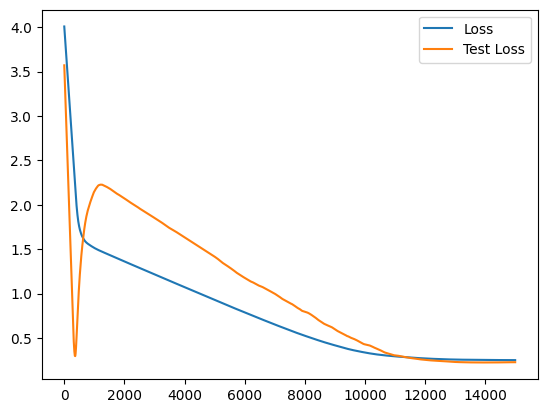

In [ ]:
plt.plot(epoch_list, loss_list, label = "Loss")
plt.plot(epoch_list, test_loss_list, label = "Test Loss")
plt.legend()

### 6.4 Make Predictions

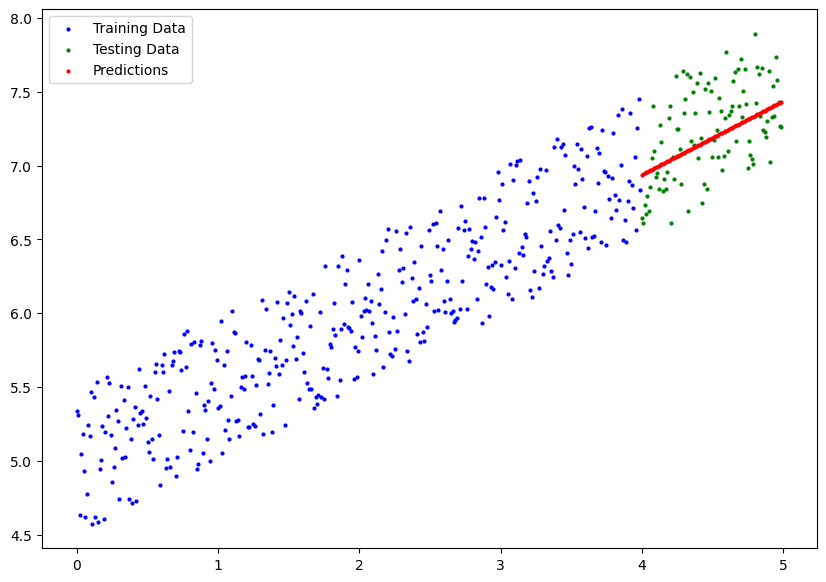

In [ ]:
# Make Predictions
with torch.inference_mode():
  y_pred = lrModel(X_test)

plot_predictions(predictions = y_pred)

In [ ]:
lrModel.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.4989]])),
             ('linear_layer.bias', tensor([4.9435]))])

### 6.5 Saving & Loading

In [ ]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workdlow_lrModel.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save model's state_dict
print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(obj=lrModel.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to models/01_pytorch_workdlow_lrModel.pth


In [ ]:
# Load a the model to a new instance
loaded_lrModel = LRModel()
loaded_lrModel.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Send it to proper device
loaded_lrModel.to(device)

LRModel(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [ ]:
# Evaluate loaded model
loaded_lrModel.eval()
with torch.inference_mode():
  loaded_ypred = loaded_lrModel(X_test)

# Check if all predictions are the same
torch.tensor(y_pred == loaded_ypred).unique()

<ipython-input-18-567eed0fbcbc>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_pred == loaded_ypred).unique()


tensor([True])